## ResNet


In [30]:
import glob
import os
import random
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D

warnings.filterwarnings('ignore')


In [31]:
%run data.ipynb

Total Trainable Data:  5606
Training set size:  60
Validation set size:  20
Test set size:  20
Found 42 validated image filenames belonging to 15 classes.
Found 17 validated image filenames belonging to 15 classes.
Found 17 validated image filenames belonging to 15 classes.


In [32]:
gpus = tf.config.list_physical_devices('GPU')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    if gpus:
        device = '/GPU:0'
    else:
        device = '/CPU:0' 
print("Using device:", device)

Using device: /CPU:0


In [33]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10
input_shape = (224, 224, 3) 
num_classes = 15

In [34]:
def block(x, filters, strides=1):
    identity = x
    x = Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1 or identity.shape[-1] != filters:
        identity = Conv2D(filters, 1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)
    
    x += identity
    x = Activation('relu')(x)
    return x
def create_resnet():
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = block(x, 64)
    x = block(x, 64)
    x = block(x, 64)

    x = block(x, 128, 2)
    x = block(x, 128)
    x = block(x, 128)
    x = block(x, 128)

    x = block(x, 256, 2)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)

    x = block(x, 512, 2)
    x = block(x, 512)
    x = block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [35]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=validation_generator,
        callbacks=[ModelCheckpoint(os.path.join("files", "model.keras"), monitor='val_loss', verbose=1, save_best_only=True)]
    )
    return history

In [36]:
resnet = create_resnet()
history_resnet = run_experiment(resnet)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5898 - auc: 0.5035 - loss: 0.9367  
Epoch 1: val_loss improved from inf to 0.68809, saving model to files/model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5905 - auc: 0.5033 - loss: 0.9343 - val_accuracy: 0.6000 - val_auc: 0.5317 - val_loss: 0.6881
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6573 - auc: 0.5716 - loss: 0.7649
Epoch 2: val_loss did not improve from 0.68809
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6604 - auc: 0.5766 - loss: 0.7620 - val_accuracy: 0.4784 - val_auc: 0.2776 - val_loss: 0.7494
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6990 - auc: 0.6017 - loss: 0.6251
Epoch 3: val_loss did not improve from 0.68809
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7015 - auc: 0.6018 - loss: 0.6217 - val_accuracy: 0.4431 - val_auc: 0.2751 - val_loss: 0.7160
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8132 - auc: 0.7022 - loss: 0.4513
Epoch 4: 

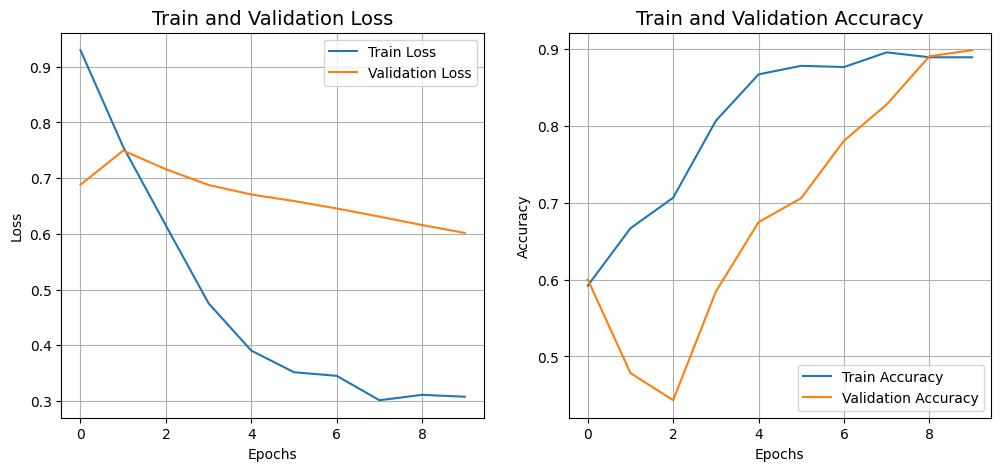

In [37]:

def plot_combined_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1) 
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2) 
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # plt.savefig('combined_history_resnet.png')
    plt.show()

plot_combined_history(history_resnet)
